# DSP Nucleus Counting with Mask RCNN
Visual walk-through of the model on DSP image data. 

## Supervised Learning
In order to train the model, we need a large set of image data that has been pre-labeled with known truths, called our training set: 
![model_image.png](model_image.png)

### Training Set
In an ideal world, we would be able to provide the model with an image and a label for every possible scenario, but that would also negate the entire purpose of using a machine learning approach. Our goal is to show the computer as many images as we can, that represent the largest proportion of what we would expect to see from our DSP image data: 
- Clearly labeled nucleus, distinguishable from background
- As close to what our real life images will look like as possible
- The more data the better
- The more scenarios, filters, rotations we can provide, the better

## MaskRCNN
Once we have generated a reliable training set, we can being training our model. We'll use a model called Mask-RCNN, developed by Facebook for facial recognition. 

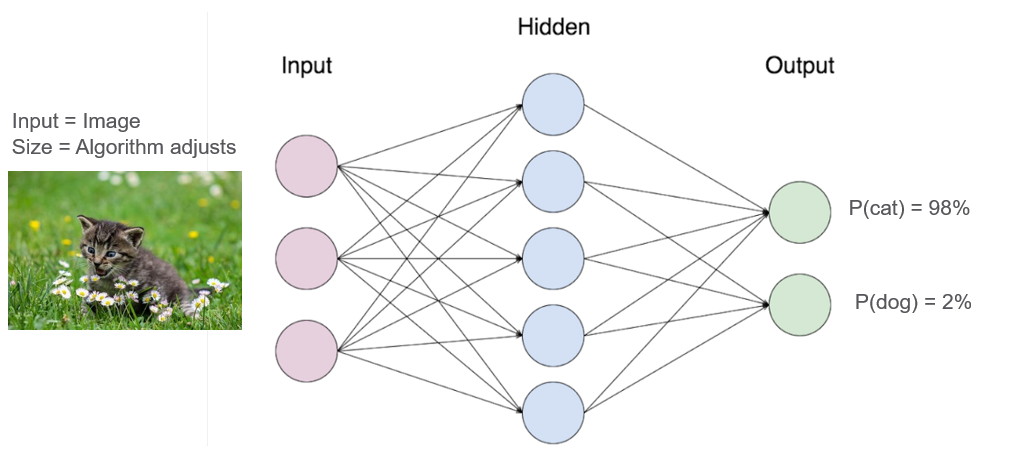

### Step 1: Load the dataset

In [1]:
# importing required packages
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

# Root directory of the project
ROOT_DIR = "./"

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
import utils
import visualize
from visualize import display_images
import model as modellib
from model import log

import nucleus

%matplotlib inline 

# Directory to save logs and trained model
LOGS_DIR = os.path.join(ROOT_DIR, "logs")

Configuring parameters. 



Using TensorFlow backend.


In [2]:
# Dataset directory
DATASET_DIR = os.path.join(ROOT_DIR, "datasets/")

# Use configuation from nucleus.py, but override
# image resizing so we see the real sizes here
class NoResizeConfig(nucleus.NucleusConfig):
    IMAGE_RESIZE_MODE = "none"
    
config = NoResizeConfig()

In [11]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# Only inference mode is supported right now
TEST_MODE = "training"

In [3]:
# setting visualization preferences
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
# create path to dataset image directory
dataset_dir = os.path.join(DATASET_DIR, "stage1_train")
all_image_ids = os.listdir(dataset_dir)

### Step 2: Split dataset into training and test sets
![train_test](train_test.png)
In machine learning models, we split our input datasets into two sets: 
    - The first set, our training set, we use to train the model
    - The second set, our test set, we use to test the predictions of our trained models
The data that is held aside for testing, usually about 30% of the data, is never used to train our model. We run this test set through the model after training, then check the accuracy of the predictions our model makes against the labels from the test set. 

In [7]:
# Load training dataset
dataset = nucleus.NucleusDataset()
dataset.load_nucleus(DATASET_DIR, "train", all_image_ids)

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 14
Class Count: 2
  0. BG                                                
  1. nucleus                                           


We can see that we have 14 images in this subest of data and two labels (classes), background and nucleus. The goal of our model is to provide a label (classification) for every object in our image; either background or nucleus, as well as a measurement of certainty in the classification. 

### Step 3: Import Configuration Options
In the background, we specify the parameters for initializing our neural network that we think will work best with our dataset. Of particular importance for our dataset are:  

![neuron](neuron.png)

- **Backbone**- Rather than creating our own neural net architecture, we will import a well-tested architecture that has been demonstrated to work well on computer vision tasks, resnet101 that rapidly trains the network with more than 150 layers. This model uses an activation function that minimizes the issue of vanishing gradients
- **Weights**- Weights in a neural networks signify how much influence each neuron has on the outcome. Since we don't know this to being with, weigths were traditionally initialized randomly. However, we can benefit from a process called transfer learning that allows us to initialize our model with MSCOCO weights- a set of weights that were trained by Microsoft on over 100,000 different images. While this image set has not seen cellular data, it is already adept at distinguishing curves, spots, background, etc and will allow us to train faster and more accurately
- As we train and test our model, we will need to adjust the number of times we run back and forth through the network (**epochs**) and the **learning rate** (how large our steps are in gradient descent)

In [9]:
# Dataset directory
DATASET_DIR = os.path.join(ROOT_DIR, "datasets/")

# Inference Configuration
config = nucleus.NucleusInferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

### Step 4: Instantiate our Model
Now that our parameters are set and our data is loaded, we can instantiate our model, a recurrent neural network: 

In [72]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)

### Step 5: Load Weights
Once we have completed a round of training, we can start off with the weights we generated from a previous run. This allows us to add to and improve our learning each time we run the model. 

In [14]:
# Path to a specific weights file
weights_path = "./mask_rcnn_coco.h5"

# Or, load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path,
                       by_name=True,
                       exclude=[
                           "mrcnn_class_logits", "mrcnn_bbox_fc",
                            "mrcnn_bbox", "mrcnn_mask"])

Loading weights  ./mask_rcnn_coco.h5


### Step 6: Train the Model
And finally, we can begin training our model. 

#### Generate Region Proposals
First, the neural network scans the image in sections and uses difference in pixel color and intensity to marks regions that it suspects contain nucleus, called **Region Proposals**. 

#### Create Bounding Boxes
Once the regions are proposed, the algorithm next uses a set of anchors to draw bounding boxes around the area, one for each potential size of nucleus that could be contained in the area: 

In [17]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)

In [64]:
class RandomCropConfig(nucleus.NucleusConfig):
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

crop_config = RandomCropConfig()

# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, crop_config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [65]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph(image[np.newaxis], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
], image_metas=image_meta[np.newaxis])

rpn_class                shape: (1, 16368, 2)         min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.02218  max:    1.00650  float32
refined_anchors          shape: (1, 6000, 4)          min:  -56.71296  max:   57.45695  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (100,)                min:    0.00000  max: 5999.00000  int32
proposals                shape: (1, 100, 4)           min:    0.00000  max:    1.00000  float32


anchors                  shape: (16368, 4)            min:  -91.00000  max:  283.00000  int32
refined_anchors          shape: (70, 4)               min:    0.00000  max:  256.00000  float32
Positive anchors: 70
Negative anchors: 186
Neutral anchors: 16112
BG                     : 86
nucleus                : 42


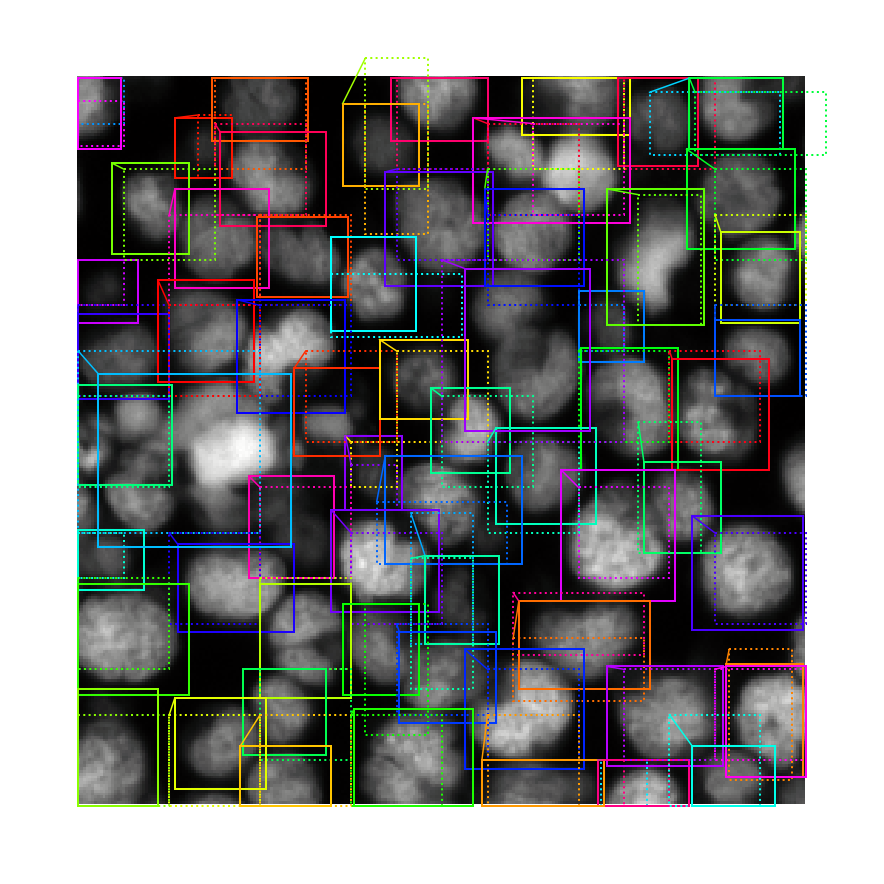

In [66]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

- Anchor boxes are created for the size and scale of each object class (aka nucleus)
- Anchors are then tiled across region proposals
- A neural network uses the info from the intersection over union of these anchors to refine the box boundaries
- A binary classification is made between background and potential nucleus

#### Refine Bounding Boxes
We'll use the overlap of the bounding boxes to refine the location of the nucleus and combine this information into a single bounding box: 

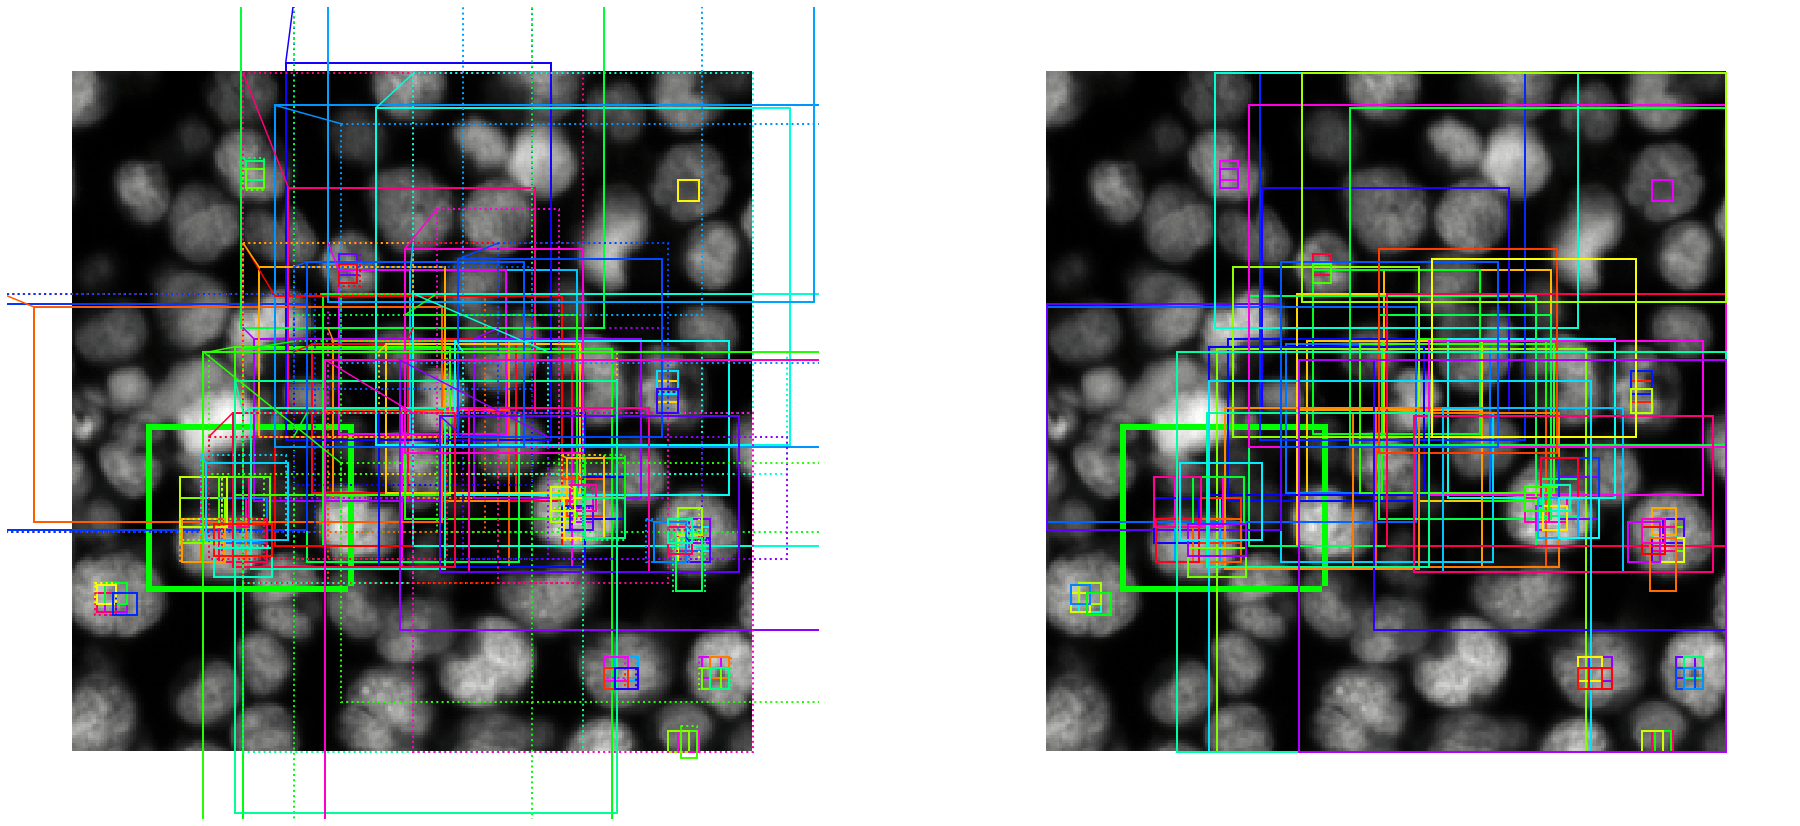

In [37]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 100
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

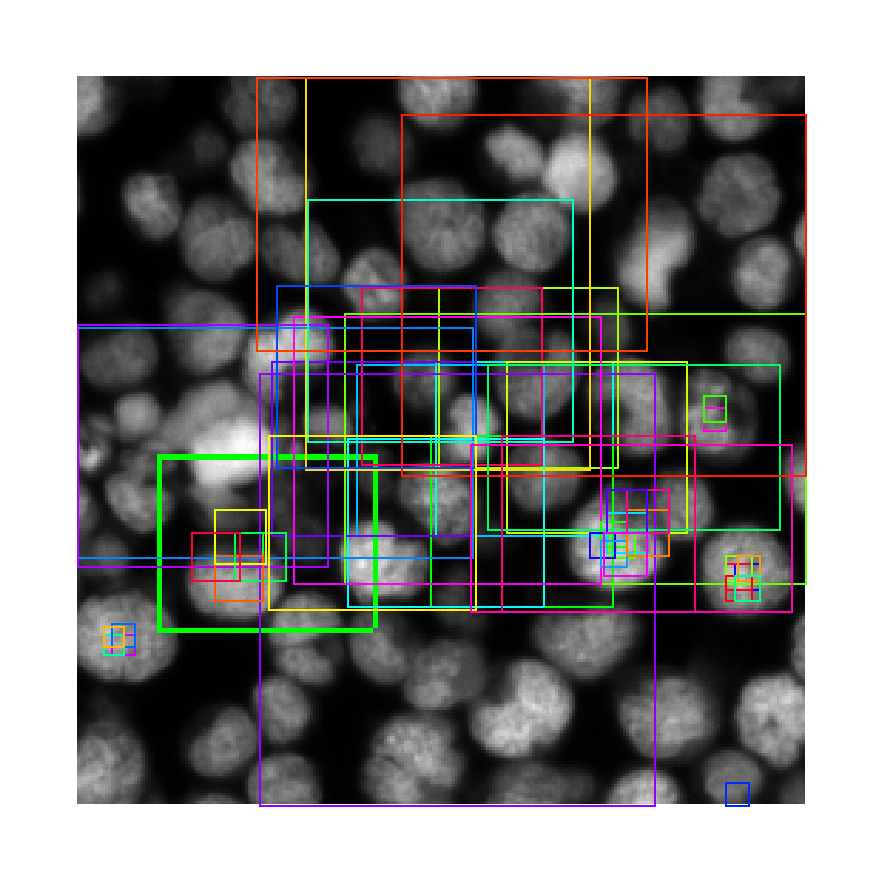

In [39]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
# h, w = config.IMAGE_SHAPE[:2]
# proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(
    image, ax=get_ax(),
    refined_boxes=utils.denorm_boxes(rpn['proposals'][0, :limit], image.shape[:2]))

#### Generate Masks and Make Predictions
After the bounding boxes have been refined, we draw a polygon mask around each nucleus, and return the probability that given the model, what we are seeing is indeed a nucleus. 

In [101]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 2000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 2000, 2)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 2000, 2, 4)       min:  -29.80621  max:   33.63739  float32
masks                    shape: (1, 400, 28, 28, 2)   min:    0.00001  max:    0.99993  float32
detections               shape: (1, 400, 6)           min:    0.00000  max:    1.00000  float32


100 detections: {'nucleus'}


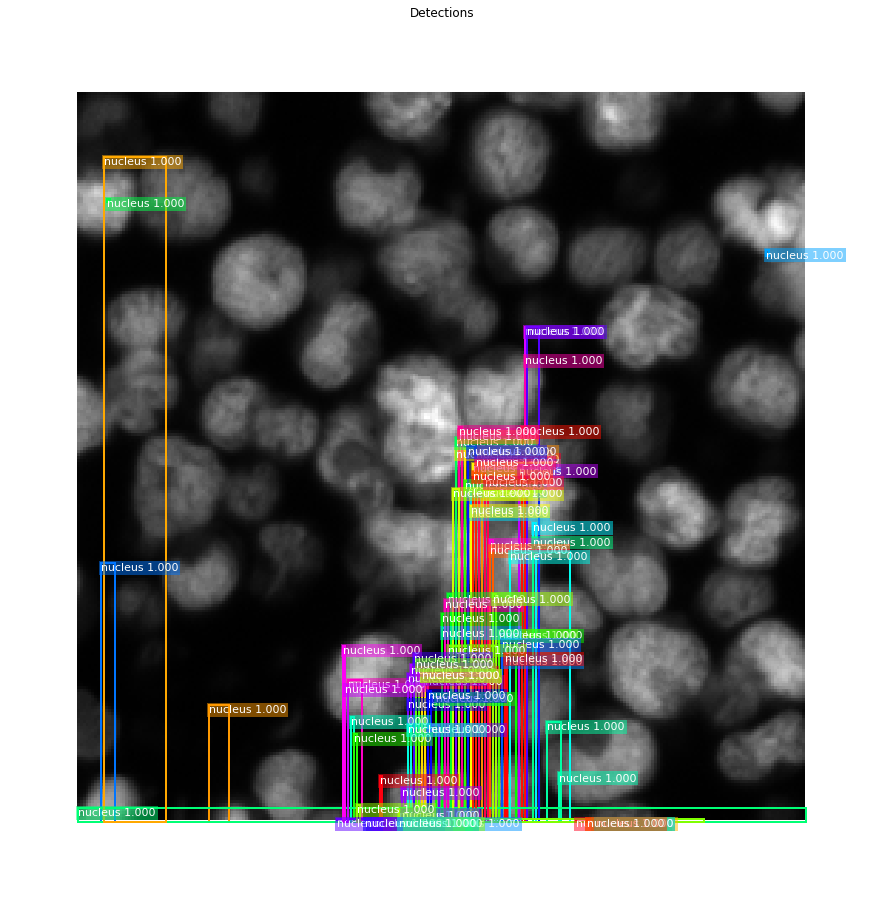

In [102]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = 100 #np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, set(np.array(dataset.class_names)[det_class_ids])))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

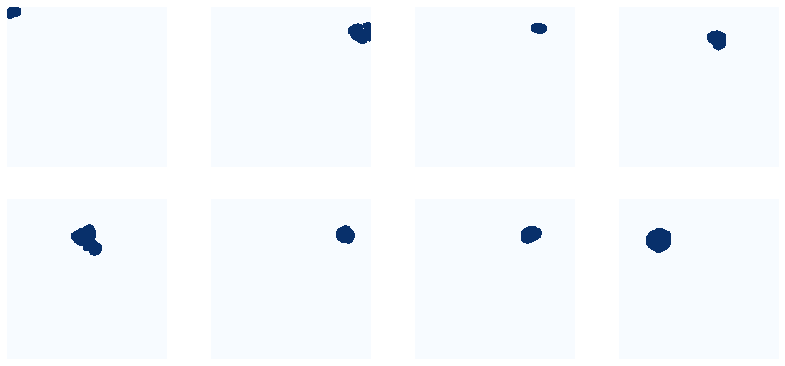

In [69]:
limit = 8
display_images(np.transpose(gt_mask[..., :limit], [2, 0, 1]), cmap="Blues")

### Step 7: Test the accuracy of the model
We've created a model, trained it on our dataset and made predictions... but how accurate are those predictions? In this final step we measure the accuracy of the model by making predictions on that test set we held aside. We make predictions using our model, and then compmare those with the labeled ground truth masks. 

In [120]:
config.DETECTION_MAX_INSTANCES=400
config.DETECTION_MIN_CONFIDENCE=0
config.DETECTION_NMS_THRESHOLD=0.3
config.MAX_GT_INSTANCES=1000
config.POOL_SIZE=7
config.POST_NMS_ROIS_INFERENCE=2000
config.POST_NMS_ROIS_TRAINING=1000
config.PRE_NMS_LIMIT=6000
config.ROI_POSITIVE_RATIO=0.33
config.RPN_ANCHOR_RATIOS=[0.5, 1, 2]
config.RPN_ANCHOR_SCALES=(8, 16, 32, 64, 128)
config.RPN_ANCHOR_STRIDE=1
config.RPN_NMS_THRESHOLD=0.8
config.RPN_TRAIN_ANCHORS_PER_IMAGE=256
config.TRAIN_ROIS_PER_IMAGE=200

In [121]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)

Gathering image paths. 

image ID: nucleus.Scan_293T_CPA_ROI_038_5x4 (10) Scan_293T_CPA_ROI_038_5x4
Original image shape:  [256 256   3]
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
gt_class_id              shape: (54,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (54, 4)               min:    0.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 54)        min:    0.00000  max:    1.00000  bool


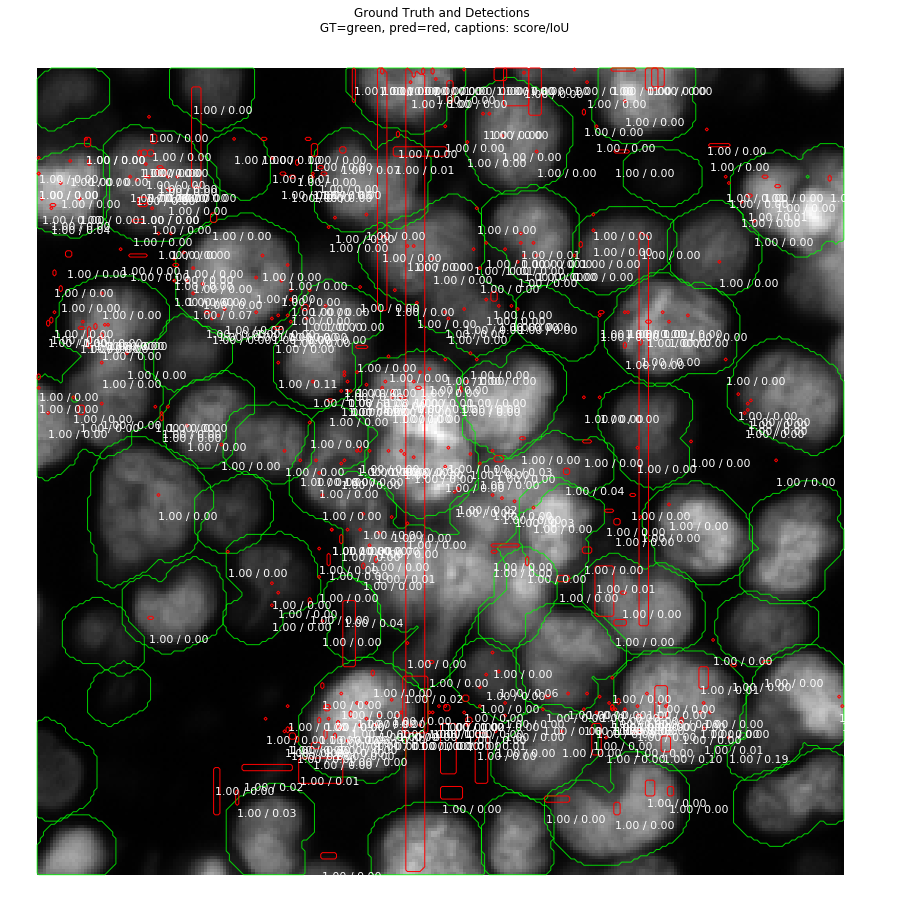

In [122]:
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[:100][0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)

Keep in mind, we trained that model using just one image. What happens if we try it on 5 images? 


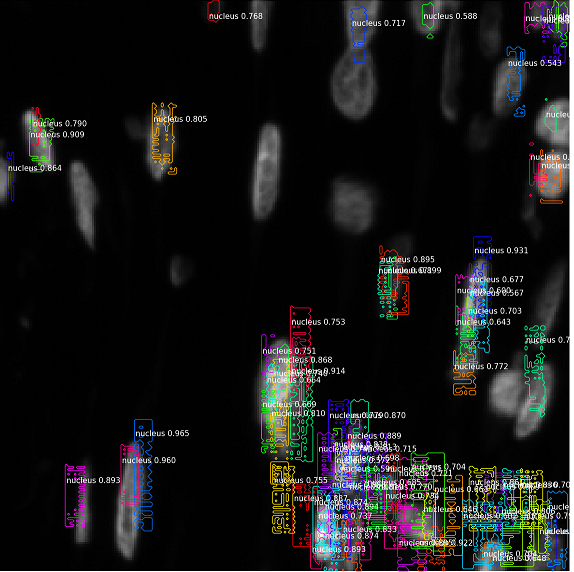

## What do we have in place now? 
- A working, reusable pipeline and model that has been run on our DSP image data
- A newly released and improved set of training data that we will begin to label by hand and augment
- Evidence that the model improves on our dataset with increased training samples and increased number of epochs

## Next Steps: 
- Manually label training images
- Meet to review manually labeled images and make consistent decision policies on labeling of difficult areas
- Augment hand labeled images with varying rotations, blurs, intensities and distortion to supplement training data and improve generalization (decrease risk of overfitting)
- Test effects of various parameter tweaks and varying epochs (based on research from previous papers) and measure impact
- Test on increasingly larger data sets to measure differences in accuracy
- Train on AWS